In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import math
import datetime

In [2]:
A = './gps_data/AI Tracks at Sea High Frequency GPS_6.txt'
B = './gps_data/AI Tracks at Sea High Frequency GPS_18 and 19.txt'
C = './gps_data/gps_train.txt'
mapping = [C,C,C,C,C,C,C,C,B,B,C,C,A,C,C,C]
cam_lon = -117.234631
cam_lat = 32.7029769
fps = 25

In [138]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [185]:
# for each csv of manually labeled bounding boxes
for map_idx,file in enumerate(glob.glob('./labeling_files/*.csv')):
    print(file)
    b=[int(i) for i in file if i.isdigit()]
    if len(b) == 2:
        c = 10*b[0] + b[1]
    else:
        c = b[0]
        
    #retreive path to gps data
    path = mapping[map_idx]
    
    #open bounding boxes
    screendata = np.genfromtxt(file, delimiter=',')
    
    #read gps locations and corresponding UTC timestamps
    with open(path, 'r') as file:
        output = file.readlines()
    trkpts = []
    stamps = []
    for line in output:
        if '<trkpt' in line:
            trkpts.append((float(line.split("\"")[1]), float(line.split("\"")[3])))
        elif 'time' in line:
            stamps.append(line.split('        <time>')[1].split('</time>\n')[0])
    trkpts = np.array(trkpts)
    
    #extract times from timestamps
    new_gps_timestamps = []
    for stamp in stamps:
        new_gps_timestamps.append(stamp.split('T')[1][:-1])
        
    #get relative gps locations
    trkpts_rel = np.array([(t-cam_lat,n-cam_lon) for t,n in trkpts])
    
    #get bottom center of bounding boxes 
    bboxes = screendata[:,1:]
    center = []
    for xLeft, yTop, width, height in bboxes:
        xMin = math.ceil(xLeft)
        xMax = xMin + width - 1
        yMin = math.ceil(yTop)
        yMax = yMin + height - 1
        cx = xLeft+width/2
        cy = yTop+height
        center.append((cx-1280,cy-720))
        
    #read camera timestamps and fill zeros
    log = [i for i in os.listdir('./camera_gps_logs/') if str(c) in i and 'cleaned' in i]
    camera_df = pd.read_csv('./camera_gps_logs/'+log[0])
    first_labeled = camera_df.loc[camera_df.estimated_time != '00:00:00']['estimated_time'].iloc[0]
    first_labeled_frame = camera_df.loc[camera_df.estimated_time != '00:00:00']['Frame No.'].iloc[0]
    num_first_labeled = len(camera_df.loc[camera_df.estimated_time == first_labeled])

    if first_labeled_frame > 0:
        if num_first_labeled < 25:
            for i in range(first_labeled_frame-1,first_labeled_frame-(26-num_first_labeled),-1):
                camera_df['estimated_time'].iloc[i] = first_labeled
                first_labeled_frame = i
#         for j in range(first_labeled_frame):
#             print(j)
#             prev_time = datetime.datetime.strptime(first_labeled, '%H:%M:%S') - datetime.timedelta(seconds = (first_labeled_frame-j)/fps)
#             print(str(prev_time.time()))
#             camera_df['estimated_time'].iloc[j] = str(prev_time.time())
        prev_time = datetime.datetime.strptime(first_labeled, '%H:%M:%S') - datetime.timedelta(seconds = 1)
        for j in range(first_labeled_frame):
            camera_df['estimated_time'].iloc[j] = str(prev_time.time())
    
    frame_frequencies = dict(camera_df.estimated_time.value_counts())
    
    #append fractions of a second to each camera timestep
#     for i, stamp in enumerate(camera_df.estimated_time):
#         offset = (fps-first_labeled_frame)/fps + i/fps
#         camera_df.estimated_time[i] = stamp + str(round(offset - int(offset),2))[1:]

    timesteps = []
    for i, stamp in enumerate(camera_df.estimated_time):
        if i == 0:
            t = 0
        else:
            t += 1/frame_frequencies[stamp]
        timesteps.append(t)
        
    camera_df['time'] = timesteps

    for stamp in camera_df.estimated_time.unique():
        start = camera_df.estimated_time[camera_df.estimated_time == stamp].index[0]
        fps = frame_frequencies[stamp]
        for i in range(fps):
            offset = (i)/fps
            camera_df.estimated_time[start+i] = stamp + str(round(offset - int(offset),2))[1:]
            
    #interpolate gps timestamps
    gps_stamps = pd.DataFrame(stamps, columns=['timestamp'])
    frequencies = dict(gps_stamps.timestamp.value_counts())
    for stamp, count in frequencies.items():
        for i,(index,val) in enumerate(zip(gps_stamps[gps_stamps.timestamp == stamp].index, gps_stamps[gps_stamps.timestamp == stamp].timestamp)):
            offset = (i+1)/25*int(25/(count+1))
            try:
                stamp = stamp.split('T')[1].split('Z')[0]
            except:
                stamp = stamp.split('T')[0]
            gps_stamps.timestamp.iloc[index] = stamp + str(offset - int(offset))[1:]
            
    gps_stamps['gps_lat'] = trkpts[:,0]
    gps_stamps['gps_lon'] = trkpts[:,1]
    gps_stamps['gps_lat_rel'] = trkpts_rel[:,0]
    gps_stamps['gps_lon_rel'] = trkpts_rel[:,1]
    
    #add gps ground truth to camera df
#     lat = []
#     lon = []
#     for i,stamp in enumerate(camera_df.estimated_time):
#         if str(stamp) in gps_stamps.timestamp.values:
#             lat.append(gps_stamps[gps_stamps.timestamp == stamp].iloc[0].lat)
#             lon.append(gps_stamps[gps_stamps.timestamp == stamp].iloc[0].lon)
#         else:
#             lat.append(None)
#             lon.append(None)

    camera_df['gps_lat'] = None
    camera_df['gps_lon'] = None
    start = datetime.datetime.strptime(camera_df.estimated_time[0], '%H:%M:%S.%f')
    end = datetime.datetime.strptime(camera_df.estimated_time.iloc[-1], '%H:%M:%S.%f')
    seconds = camera_df.time.values
    for i,stamp in enumerate(gps_stamps.timestamp):
        stamp = datetime.datetime.strptime(stamp, '%H:%M:%S.%f')
        if stamp >= start and stamp <= end:
            delta = (stamp - start).total_seconds()
            idx = find_nearest(seconds, delta)
            camera_df.gps_lat[idx] = gps_stamps.gps_lat[i]
            camera_df.gps_lon[idx] = gps_stamps.gps_lon[i]
            
    camera_df['gps_lat_rel'] = camera_df.gps_lat - cam_lat 
    camera_df['gps_lon_rel'] = camera_df.gps_lon - cam_lon
    
    #add in screendata
    camera_df['x'] = screendata[:,1]
    camera_df['y'] = screendata[:,2]
    camera_df['width'] = screendata[:,3]
    camera_df['height'] = screendata[:,4]
    camera_df['x_cent'] = (camera_df.x + camera_df.width/2).round()
    camera_df['y_cent'] = (camera_df.y + camera_df.height).round()
    
    #filtering interpolating gps locations
    data = camera_df
    data_filt = data.dropna()
    data_filt['dlat'] = np.gradient(data_filt.gps_lat_rel.values,data_filt.time.values)
    data_filt['dlon'] = np.gradient(data_filt.gps_lon_rel.values,data_filt.time.values)
    data_filt['d2lat'] = np.gradient(data_filt.dlat.values,data_filt.time.values)
    data_filt['d2lon'] = np.gradient(data_filt.dlon.values,data_filt.time.values)
    data_filt['d3lat'] = np.gradient(data_filt.d2lat.values,data_filt.time.values)
    data_filt['d3lon'] = np.gradient(data_filt.d2lon.values,data_filt.time.values)
    data_filt['d4lat'] = np.gradient(data_filt.d3lat.values,data_filt.time.values)
    data_filt['d4lon'] = np.gradient(data_filt.d3lon.values,data_filt.time.values)

    lat_interp = np.interp(data.time.values.astype(np.float64),data_filt.time.values.astype(np.float64),data_filt.gps_lat_rel.values.astype(np.float64))
    lon_interp = np.interp(data.time.values.astype(np.float64),data_filt.time.values.astype(np.float64),data_filt.gps_lon_rel.values.astype(np.float64))
    data['lat_int'] = lat_interp
    data['lon_int'] = lon_interp
    
    #saving
    data.to_csv(f'./fully_correlated_data/data_{c}.csv', index = False)
    data_filt.to_csv(f'./fully_correlated_data/data_filt_{c}.csv', index = False)

./labeling_files\10.csv


D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A v

./labeling_files\11.csv
./labeling_files\12.csv
./labeling_files\13.csv
./labeling_files\14.csv
./labeling_files\15.csv
./labeling_files\16.csv
./labeling_files\17.csv
./labeling_files\18.csv


ValueError: unconverted data remains: 0000000001

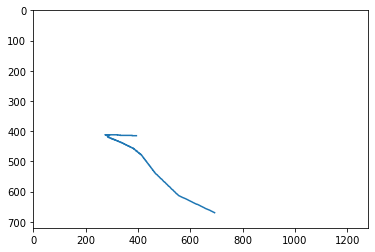

In [198]:
plt.xlim(left=0,right=1280)
plt.ylim(top=0,bottom=720)
plt.plot(data.x_cent,data.y_cent)